# Set Up
Set up the Google Colab environment and import dependent libraries.

In [1]:
#Loading data from Google drive
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir("/content/drive/My Drive/PAN14_Code")
  RUNNING_COLAB = True
except ImportError:
  print("I have a sneaking suspicion that I'm not running on Google Colab")
  RUNNING_COLAB = False


Mounted at /content/drive


In [2]:
# Lambda to print module versions
ver = lambda module : print(f"{module.__name__}=={module.__version__}")

In [3]:
import json
import math
import csv
import numpy as np
import glob
import pickle
import itertools
from collections import Counter

#pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download(["punkt", "stopwords","wordnet"])

#pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping

#pip install gensim
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

#pip install skikit-learn
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from collections import defaultdict

#pip install networkx
import networkx as nx
import random
from tqdm import tqdm
from urllib.request import urlretrieve

#pip install matplotlib
import matplotlib.pyplot as plt
import string

In [4]:
def nltk_setup(path = None):
  """Initialize and download the right modules"""
  if path == None:
    # No change to default path (defaults to user home directory)
    nltk.download(["punkt", "stopwords","wordnet"])
  else:
    # Change default path
    nltk.data.path.insert(path, 0)
    nltk.download(["punkt", "stopwords","wordnet"], download_dir=nltk.data.path[0])

if RUNNING_COLAB:
  nltk_setup()
else:
  nltk_setup(os.curdir())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Data Process
Read the data in and save it in the dict.

In [5]:
def get_data_directory_path(subdirectory):
    return os.path.join('data', subdirectory)


def get_json_file_path(data_directory, file_name):
    return os.path.join(data_directory, file_name)


def read_json_file(file_path):
    with open(file_path) as file:
        data = json.load(file)
    return data


def extract_text_from_files(file_paths):
    known_text, unknown_text = [], []

    for file_path in file_paths:
        text_lines = []
        with open(file_path, 'r') as file:
            for line in file:
                cleaned_line = line.strip().lstrip("\ufeff")
                text_lines.append(cleaned_line)
        if 'unknown' in file_path:
            unknown_text.append(text_lines)
        else:
            known_text.append(text_lines)

    return known_text, unknown_text


def build_corpus(data_directory, content_data, label_data):
    corpus = {}

    for index in tqdm(range(len(content_data['problems']))):
        problem_file_paths = glob.glob(os.path.join(data_directory, content_data['problems'][index], '*'))

        if not problem_file_paths:
            continue

        known_text, unknown_text = extract_text_from_files(problem_file_paths)
        label = 1 if label_data['problems'][index]['answer'] == 'Y' else 0

        corpus[index] = {
            'known': known_text,
            'unknown': unknown_text,
            'label': label
        }

    return corpus

In [6]:
# Get data path
train_data_directory = get_data_directory_path('train_data')
# validation_data_directory = get_data_directory_path('val_data')
test_data_directory = get_data_directory_path('test_data')

In [7]:
# Train
train_content = read_json_file(get_json_file_path(train_data_directory, 'contents.json'))
train_labels = read_json_file(get_json_file_path(train_data_directory, 'truth.json'))
# # Val
# validation_content = read_json_file(get_json_file_path(validation_data_directory, 'contents.json'))
# validation_labels = read_json_file(get_json_file_path(validation_data_directory, 'truth.json'))
# Test
test_content = read_json_file(get_json_file_path(test_data_directory, 'contents.json'))
test_labels = read_json_file(get_json_file_path(test_data_directory, 'truth.json'))

In [8]:
# Get train corpus
train_corpus = build_corpus(train_data_directory, train_content, train_labels)
# # Get val corpus
# val_corpus = build_corpus(validation_data_directory, validation_content, validation_labels)
# Get test corpus
test_corpus = build_corpus(test_data_directory, test_content, test_labels)

100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


In [9]:
X_idx = []
Y_idx = []

for k,v in train_corpus.items():
  X_idx.append(k)
  Y_idx.append(v['label'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_idx, Y_idx, test_size=0.2, random_state=42)

In [11]:
X_1, X_2 = {}, {}

for i in range(len(X_train)):
  X_1[X_train[i]] = train_corpus[X_train[i]]

for i in range(len(X_test)):
  X_2[X_test[i]] = train_corpus[X_test[i]]

In [12]:
train_corpus = X_1
val_corpus = X_2

# Train Word2Vec Model

In [13]:
def preprocess_text(text):
    """
    Preprocess a given text by tokenizing, removing punctuation and numbers,
    removing stop words, and lemmatizing.

    Args:
        text (str): The text to preprocess.

    Returns:
        list: The preprocessed text as a list of tokens.
    """
    if not isinstance(text, str):
        text = str(text)

    # Tokenize the text into words
    tokens = word_tokenize(text.lower())

    # Remove punctuation and numbers
    table = str.maketrans('', '', string.punctuation + string.digits)
    tokens = [word.translate(table) for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if (not word in stop_words) and (word != '')]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def train_word2vec_model(data, vector_size):
    """
    Train a word2vec model using the given data.

    Args:
        data (dict): The data to use for training the model.
        vector_size (int): The size of the word vectors in the model.

    Returns:
        gensim.models.Word2Vec: The trained word2vec model.
    """
    corpus = []

    # Process all articles in the data
    for articles in tqdm(data.values(), total=len(data)):
        all_articles = []
        all_articles.extend(articles['known'])
        all_articles.extend(articles['unknown'])

        for article in all_articles:
            for line in article:
                text = line.strip()
                tokens = preprocess_text(text)
                corpus.append(tokens)

    # Train the word2vec model
    word2vec_model = gensim.models.Word2Vec(vector_size=vector_size, window=5, min_count=1, workers=4)
    word2vec_model.build_vocab(corpus)
    word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

    return word2vec_model

In [14]:
# Size of word vectors in the word2vec model
w2v_vector_size = 300

In [15]:
# Train a word2vec model using the training corpus
word2vec_model = train_word2vec_model(train_corpus, w2v_vector_size)

100%|██████████| 154/154 [00:07<00:00, 19.99it/s]


# Vectorize Text Data

In [16]:
def convert_text_to_vector(texts, model):
    """
    Convert a list of texts into their corresponding word2vec vectors
    """
    vectors = []
    for text in texts:
        words = preprocess_text(text)
        vector = np.sum([model.wv[word] for word in words if word in model.wv], axis=0)
        word_count = np.sum([word in model.wv for word in words])
        if word_count != 0:
            vector /= word_count
        else:
          vector = np.zeros(w2v_vector_size)
        vectors.append(vector)
    return vectors

In [17]:
def count_punctuations(texts):
  """
  Count the frequency of different punctuations in the texts
  """
  # Define punctuations to count
  punctuations = set(['.', ',', ';', ':', '!', '?', '-', '(', ')', '\"', '\'', '`', '/'])

  # Initialize dictionary to count punctuations
  punctuations_count = {p: 0 for p in punctuations}

  # Count punctuations in text_list
  for text in texts:
      for char in text:
          if char in punctuations:
              punctuations_count[char] += 1

  # Return list of punctuation counts
  return list(punctuations_count.values())

In [18]:
def analyze_sentence_lengths(sentences):
  """
  Analyze the lengths of sentences
  """
  sentence_lengths = [len(sentence.split()) for sentence in sentences]
  average_length = np.mean(sentence_lengths)
  count_over_avg = np.sum([length > average_length for length in sentence_lengths])
  count_under_avg = np.sum([length < average_length for length in sentence_lengths])
  count_avg = len(sentence_lengths) - count_over_avg - count_under_avg

  return [count_over_avg, count_under_avg, count_avg, average_length]

In [19]:
def analyze_words(texts):
    """
    Analyze the words used in the texts
    """
    words = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for text in texts:
        tokenized = word_tokenize(text.lower())
        processed = [lemmatizer.lemmatize(word) for word in tokenized if word not in stop_words]
        words += processed
    word_freq = nltk.FreqDist(words)
    rare_count = np.sum([freq <= 2 for word, freq in word_freq.items()])
    long_count = np.sum([len(word) > 6 for word in words])
    word_lengths = [len(word) for word in words]
    average_length = np.mean(word_lengths)
    count_over_avg = np.sum([length > average_length for length in word_lengths])
    count_under_avg = np.sum([length < average_length for length in word_lengths])
    count_avg = len(word_lengths) - count_over_avg - count_under_avg
    ttr = len(set(words)) / len(words) if words else 0

    return [rare_count, long_count, count_over_avg, count_under_avg, count_avg, ttr]

In [20]:
def calculate_style_vector(texts):
  """
  Calculate the style vector of the texts
  """
  punctuation_vec = count_punctuations(texts)     # Punctuations stylistic features
  sentence_vec = analyze_sentence_lengths(texts)  # Sentences stylistic features
  word_vec = analyze_words(texts)                 # Words stylistic features
  word_count = np.sum([len(text.split()) for text in texts])

  vector = np.concatenate((punctuation_vec, sentence_vec, word_vec))

  return vector / word_count if word_count else vector

In [21]:
def get_vectors(texts, w2v_model):
  res = []
  for text in texts:
    w2v_vec = np.mean(convert_text_to_vector(text, w2v_model), axis=0)
    style_vec = calculate_style_vector(text)
    res.append(np.concatenate((w2v_vec, style_vec), axis=None))
    # res.append(w2v_vec)

  return res

In [22]:
def vectorize_text_data(data, w2v_model):
  """
  Build author data from the corpus
  """
  res = {}
  for key,val in tqdm(data.items(), total=len(data)):
    if len(val['unknown']) == 0:
      continue
    res[key] = {
        'known': get_vectors(val['known'], w2v_model),
        'unknown': get_vectors(val['unknown'], w2v_model),
        'label': val['label']
    }

  return res

In [23]:
train_data = vectorize_text_data(train_corpus, word2vec_model)
val_data = vectorize_text_data(val_corpus, word2vec_model)
test_data = vectorize_text_data(test_corpus, word2vec_model)

100%|██████████| 200/200 [00:16<00:00, 12.31it/s]


# Build Triplet Samples

In [24]:
# Random triplet mining
def build_random_triplet_sample(data):
  """
  This function creates random triplet samples from the input data
  """

  keys_list = list(data.keys())
  triplet_samples = {}

  # Initialize the lists for storing the anchor, positive, and negative samples
  anchors, positives, negatives = [], [], []

  for key,val in tqdm(data.items(), total=len(data)):
    n = len(val['known'])
    for i in range(n):
      for j in range(i+1, n):
        anchors.append(val['known'][i])
        positives.append(val['known'][j])
        # Get negative sample
        while True:
          random_key = random.choices(keys_list, k=1)
          if random_key != key:
            break
        random_neg_sample = random.choices(data[random_key[0]]['known'], k=1)
        negatives.append(random_neg_sample[0])


  # Build triplet sample
  for i in range(len(anchors)):
    triplet_samples[i] = {
        'anchor': anchors[i],
        'positive': positives[i],
        'negative': negatives[i]
    }

  return triplet_samples

In [25]:
random_triplet_samples = build_random_triplet_sample(train_data)

100%|██████████| 152/152 [00:00<00:00, 55831.00it/s]


In [26]:
anchor_data = np.array([data['anchor'] for data in random_triplet_samples.values()])
positive_data = np.array([data['positive'] for data in random_triplet_samples.values()])
negative_data = np.array([data['negative'] for data in random_triplet_samples.values()])
labels_data = np.array([0 for _ in random_triplet_samples.values()])

In [27]:
val_random_triplet_samples = build_random_triplet_sample(val_data)

100%|██████████| 39/39 [00:00<00:00, 33540.67it/s]


In [28]:
val_anchor_data = np.array([data['anchor'] for data in val_random_triplet_samples.values()])
val_positive_data = np.array([data['positive'] for data in val_random_triplet_samples.values()])
val_negative_data = np.array([data['negative'] for data in val_random_triplet_samples.values()])
val_labels_data = np.array([0 for _ in val_random_triplet_samples.values()])

# Build SiameseNet Model

## Model Frame

In [29]:
class SiameseNet(tf.keras.Model):
    def __init__(self, base_network, clf_network):
        super().__init__()
        self.base = base_network
        self.clf = clf_network

    def call(self, inputs):
        anchor = inputs[0]
        positive = inputs[1]
        negative = inputs[2]

        output_anchor = self.base(anchor)
        output_positive = self.base(positive)
        output_negative = self.base(negative)

        # Anchor - Positive
        x1 = tf.concat([output_anchor, output_positive], axis=-1)
        x1_out = self.clf(x1)

        # Anchor - Negative
        x2 = tf.concat([output_anchor, output_negative], axis=-1)
        x2_out = self.clf(x2)

        return (x1_out, x2_out)

In [30]:
def create_dense_block(x, units, dropout_rate, l1_reg, l2_reg):
    x = tf.keras.layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return tf.keras.layers.Dropout(dropout_rate)(x)

In [31]:
# Define the base network
def create_base_network(embedding_dim, dropout_rate=0.4, l1_reg=0.001, l2_reg=0.001):
    input = tf.keras.layers.Input(shape=embedding_dim)
    x = tf.keras.layers.BatchNormalization()(input)

    x = create_dense_block(x, 256, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 128, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 64, dropout_rate, l1_reg, l2_reg)

    x = tf.keras.layers.Dense(64, activation='linear')(x)

    return tf.keras.Model(inputs=input, outputs=x)

In [32]:
def create_clf_network(input_shape, dropout_rate=0.5, l1_reg=0.003, l2_reg=0.003):
    input = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.BatchNormalization()(input)

    x = create_dense_block(x, 128, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 64, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 32, dropout_rate, l1_reg, l2_reg)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=input, outputs=x)


In [33]:
def customer_loss(y_true, y_pred):
    AP = y_pred[0]
    AN = y_pred[1]

    loss = 1.0 - AP + AN

    return loss

## Construct the Model

In [34]:
# Define the embedding dimension
embedding_dim = anchor_data[0].shape

# Create base network
base_network = create_base_network(embedding_dim)
clf_network = create_clf_network(base_network.output_shape[1]*2)

siamese_model = SiameseNet(base_network, clf_network)

In [35]:
input_anchor = tf.keras.layers.Input(shape=embedding_dim)
input_positive = tf.keras.layers.Input(shape=embedding_dim)
input_negative = tf.keras.layers.Input(shape=embedding_dim)

In [36]:
# Assemble siameseNet model
siamese_model.compile(optimizer='adam',
                      loss=customer_loss)

In [37]:
checkpoint_path = "model_weights/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

## Load SiameseNet Model Weights

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
siamese_model.load_weights(latest)

## Train SiameseNet Model

### Train on Random Triplet Samples

In [38]:
# Train siameseNet model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
siamese_history = siamese_model.fit([anchor_data, positive_data, negative_data], labels_data,
                  epochs=1000,
                  validation_data=([val_anchor_data, val_positive_data, val_negative_data], val_labels_data),
                  callbacks=[early_stopping, cp_save])

Epoch 1/1000
15/15 [==============================] - ETA: 0s - loss: 16.9051 - output_1_loss: 0.9197 - output_2_loss: 1.0787
Epoch 1: saving model to model_weights/cp.ckpt
15/15 [==============================] - 7s 58ms/step - loss: 16.9051 - output_1_loss: 0.9197 - output_2_loss: 1.0787 - val_loss: 16.8076 - val_output_1_loss: 0.9997 - val_output_2_loss: 1.0017
Epoch 2/1000
15/15 [==============================] - ETA: 0s - loss: 16.6540 - output_1_loss: 0.9923 - output_2_loss: 0.9339
Epoch 2: saving model to model_weights/cp.ckpt
15/15 [==============================] - 0s 17ms/step - loss: 16.6540 - output_1_loss: 0.9923 - output_2_loss: 0.9339 - val_loss: 16.6312 - val_output_1_loss: 0.9956 - val_output_2_loss: 1.0033
Epoch 3/1000
14/15 [===========================>..] - ETA: 0s - loss: 16.5154 - output_1_loss: 0.9222 - output_2_loss: 1.0351
Epoch 3: saving model to model_weights/cp.ckpt
15/15 [==============================] - 0s 17ms/step - loss: 16.5384 - output_1_loss: 0.9375

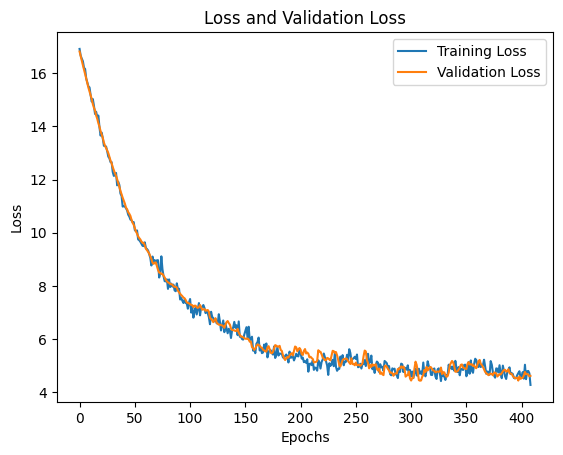

In [39]:
loss = siamese_history.history['loss']
val_loss = siamese_history.history['val_loss']

# Draw
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Train on Semi-Hard Triplet Samples

#### Semi-Hard Samples Construct

In [40]:
# Build semi-hard triplet sample candidates
def build_triplet_sample_candidates(data):
  res = {}

  keys = []
  anchors = []
  positives = []

  for key,val in tqdm(data.items(), total=len(data)):
    n = len(val['known'])
    for i in range(n-1):
      keys.append(key)
      anchors.append(val['known'][i])
      positives.append(val['known'][i+1:])

  for i in range(len(keys)):
    res[i] = {
        'key': keys[i],
        'anchor': anchors[i],
        'positives': positives[i]
    }

  return res

In [41]:
triplet_sample_candidates = build_triplet_sample_candidates(train_data)

100%|██████████| 152/152 [00:00<00:00, 173148.89it/s]


In [42]:
def create_negative_vectors_dict(data):
    negative_vectors_dict = {}
    key_list = list(data.keys())

    for key in tqdm(key_list, total=len(key_list)):
        negative_vectors_dict[key] = []
        for k,v in data.items():
            if k != key:
                for vec in v['known']:
                    negative_vectors_dict[key].append(vec)
    return negative_vectors_dict

In [43]:
negative_vectors_dict = create_negative_vectors_dict(train_data)

100%|██████████| 152/152 [00:00<00:00, 20133.08it/s]


In [44]:
def select_random_from_list(input_list):
    """
    Selects a random item from a list.
    """
    return input_list[np.random.randint(0, len(input_list))]

# def select_negative_vectors(negatives, key):
#     """
#     Collects all negative vectors except for the one corresponding to the key.
#     """
#     return [vec for k,v in negatives.items() if k != key for vec in v['known']]

def get_random_triplet(sample, negatives):
    """
    This function takes a sample and negatives, and returns a random triplet of anchor, positive, and negative.
    """
    # Select the positive vector
    positive = select_random_from_list(sample['positives'])

    # Select the negative vector
    negative = select_random_from_list(negatives[sample['key']])

    return sample['anchor'], positive, negative

def get_hard_triplet(sample, negatives, base_model, clf_model,):
    """
    This function takes a sample, negatives, and a model, and returns a hard triplet of anchor, positive, and negative.
    The sample with the lowest probability is the hardest positive sample,
    while a high probability indicates that the model is confident in classifying it as positive.
    Therefore, the lowest probability implies that the model has incorrectly classified it.
    """
    anchor_rep = base_model.predict(np.array([sample['anchor']]), verbose=0)

    ### ------ Positive ------ ###
    # Compute distances between anchor and all positive vectors
    positive_reps = base_model.predict(np.array(sample['positives']), verbose=0)
    AP_reps = []
    for rep in positive_reps:
        comb = np.concatenate((anchor_rep[0], rep), axis=None)
        AP_reps.append(comb)

    # Select the hardest positive (the one with the lowest probability)
    positive_distances = clf_model.predict(np.array(AP_reps), verbose=0)
    hardest_positive = sample['positives'][np.argmin(positive_distances)]


    ### ------ Negative ------ ###
    # Collect all negative vectors and compute distances to anchor
    negative_vectors = negatives[sample['key']]
    negative_reps = base_model.predict(np.array(negative_vectors), verbose=0)
    AN_reps = []
    for rep in negative_reps:
        comb = np.concatenate((anchor_rep[0], rep), axis=None)
        AN_reps.append(comb)

    # Select the hardest negative (the one with the highest probability)
    negative_distances = clf_model.predict(np.array(AN_reps), verbose=0)
    hardest_negative = negative_vectors[np.argmax(negative_distances)]

    # # positive_distances = [compute_cosine_distance(pos_rep, anchor_rep[0]) for pos_rep in positive_reps]
    # positive_distances = [np.sum(np.square(pos_rep - anchor_rep[0])) for pos_rep in positive_reps]

    # # Select the hardest positive (the one with the largest distance)
    # hardest_positive = sample['positives'][np.argmax(positive_distances)]

    # # Collect all negative vectors and compute distances to anchor
    # negative_vectors = select_negative_vectors(negatives, sample['key'])
    # negative_reps = model.predict(np.array(negative_vectors), verbose=0)
    # negative_distances = [np.sum(np.square(neg_rep - anchor_rep[0])) for neg_rep in negative_reps]

    # # Select the hardest negative (the one with the smallest distance)
    # hardest_negative = negative_vectors[np.argmin(negative_distances)]

    return sample['anchor'], hardest_positive, hardest_negative

def get_triplet(sample, negatives, base_model, clf_model, hard_triplet_probability):
    """
    This function decides between selecting a hard triplet or a random triplet based on the hard_triplet_probability.
    """
    if np.random.rand() < hard_triplet_probability:
        # With a certain probability, choose the hardest triplet
        return get_hard_triplet(sample, negatives, base_model, clf_model)
    else:
        # Otherwise, choose a random triplet
        return get_random_triplet(sample, negatives)


#### Training on Semi-Hard Samples

In [45]:
num_epochs = 100
patience = 10
previous_loss = float('inf')

hard_triplet_probability_start=0.5
hard_triplet_probability_end=0.8

early_stopping_2 = EarlyStopping(monitor='loss', patience=patience, verbose=0)

In [ ]:
# Initial probability of selecting a hard triplet
triplet_select_probability = hard_triplet_probability_start

# Iterate over each epoch
for epoch in tqdm(range(num_epochs)):
  # Initialize empty lists for anchor, positive, negative samples and labels
  anchor_samples = []
  positive_samples = []
  negative_samples = []
  labels = []

  # Iterate over triplet samples
  for _, sample in triplet_sample_candidates.items():
    # Get the anchor, positive, negative samples
    anchor, positive, negative = get_triplet(sample, negative_vectors_dict, base_network, clf_network, triplet_select_probability)
    # Add samples to their respective lists
    anchor_samples.append(anchor)
    positive_samples.append(positive)
    negative_samples.append(negative)
    labels.append(0)

  # Convert lists to numpy arrays
  anchor_samples = np.array(anchor_samples)
  positive_samples = np.array(positive_samples)
  negative_samples = np.array(negative_samples)
  labels = np.array(labels)

  # Train the model on current epoch's data
  siamese_model.fit([anchor_samples, positive_samples, negative_samples], labels,
                    epochs=50,
                    verbose=1,
                    callbacks=[early_stopping_2, cp_save])

  # Gradually increase the probability of choosing a hard triplet
  triplet_select_probability += (hard_triplet_probability_end - hard_triplet_probability_start) / num_epochs

  # Uncomment the following section for Early Stopping
  # Check if current epoch is a 'patience' epoch
  if epoch % patience == 0 and epoch != 0:
    current_loss = siamese_model.history.history['loss'][-1]
    # Check if loss is increasing or constant, if yes, then stop training
    if current_loss >= previous_loss:
      print("Early stopping triggered. Stopping training.")
      break
    else:
      # Update previous loss with current loss
      previous_loss = current_loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.3691 - output_1_loss: 0.8817 - output_2_loss: 0.9113
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 33ms/step - loss: 4.1675 - output_1_loss: 0.7676 - output_2_loss: 0.8245
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.6666 - output_1_loss: 1.0168 - output_2_loss: 1.0795
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.6205 - output_1_loss: 1.0534 - output_2_loss: 0.9963
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.3648 - output_1_loss: 0.8179 - output_2_loss: 0.9671
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.0654 - output_1_loss: 0.6761 - output_2_loss: 0.8034
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.4164 - output_1_loss: 1.1614 - output_2_loss: 0.6397
Epoch 4: saving model to model

  1%|          | 1/100 [00:36<59:27, 36.04s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4708 - output_1_loss: 1.0480 - output_2_loss: 0.8278
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.4327 - output_1_loss: 1.0312 - output_2_loss: 0.8069
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 4.6898 - output_1_loss: 0.9366 - output_2_loss: 1.1601
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 20ms/step - loss: 4.4407 - output_1_loss: 0.8574 - output_2_loss: 0.9840
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.8688 - output_1_loss: 1.1990 - output_2_loss: 1.0566
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 26ms/step - loss: 4.8814 - output_1_loss: 1.2190 - output_2_loss: 1.0483
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.4646 - output_1_loss: 0.8588 - output_2_loss: 0.9756
Epoch 4: saving model to model

  2%|▏         | 2/100 [01:30<1:16:29, 46.84s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5500 - output_1_loss: 0.9179 - output_2_loss: 0.8389
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 24ms/step - loss: 4.7284 - output_1_loss: 1.0130 - output_2_loss: 0.9221
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.6947 - output_1_loss: 1.1308 - output_2_loss: 0.7707
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 33ms/step - loss: 4.8341 - output_1_loss: 1.1947 - output_2_loss: 0.8462
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.3088 - output_1_loss: 0.8414 - output_2_loss: 0.6740
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 48ms/step - loss: 4.2955 - output_1_loss: 0.8472 - output_2_loss: 0.6550
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.8604 - output_1_loss: 0.9510 - output_2_loss: 1.1222
Epoch 4: saving model to model

  3%|▎         | 3/100 [02:30<1:25:39, 52.99s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.1650 - output_1_loss: 0.6014 - output_2_loss: 0.8918
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.2965 - output_1_loss: 0.7197 - output_2_loss: 0.9064
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.5036 - output_1_loss: 0.8460 - output_2_loss: 0.9897
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 28ms/step - loss: 4.6164 - output_1_loss: 0.8766 - output_2_loss: 1.0722
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.8900 - output_1_loss: 1.1432 - output_2_loss: 1.0872
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 30ms/step - loss: 4.9296 - output_1_loss: 1.1814 - output_2_loss: 1.0896
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.1102 - output_1_loss: 0.8539 - output_2_loss: 0.6206
Epoch 4: saving model to model

  4%|▍         | 4/100 [03:43<1:37:16, 60.79s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5051 - output_1_loss: 1.1364 - output_2_loss: 0.7692
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 50ms/step - loss: 4.5288 - output_1_loss: 1.1463 - output_2_loss: 0.7848
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.7760 - output_1_loss: 1.0699 - output_2_loss: 1.1383
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 4.8030 - output_1_loss: 1.0419 - output_2_loss: 1.1990
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.9571 - output_1_loss: 1.1854 - output_2_loss: 1.2371
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.9571 - output_1_loss: 1.1854 - output_2_loss: 1.2371
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.9457 - output_1_loss: 1.1589 - output_2_loss: 1.2781
Epoch 4: saving model to model

  5%|▌         | 5/100 [04:54<1:42:01, 64.43s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.6789 - output_1_loss: 1.2788 - output_2_loss: 0.9509
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 4.6238 - output_1_loss: 1.2199 - output_2_loss: 0.9553
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.0387 - output_1_loss: 0.7810 - output_2_loss: 0.8012
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 4.0387 - output_1_loss: 0.7810 - output_2_loss: 0.8012
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4709 - output_1_loss: 1.0789 - output_2_loss: 0.9115
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 61ms/step - loss: 4.5490 - output_1_loss: 1.1051 - output_2_loss: 0.9623
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.7290 - output_1_loss: 0.9987 - output_2_loss: 1.2329
Epoch 4: saving model to model

  6%|▌         | 6/100 [05:56<1:39:29, 63.50s/it]

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 4.7041 - output_1_loss: 1.1342 - output_2_loss: 1.0700
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.7041 - output_1_loss: 1.1342 - output_2_loss: 1.0700
Epoch 2/50
6/8 [=====================>........] - ETA: 0s - loss: 4.8789 - output_1_loss: 1.1868 - output_2_loss: 1.1886
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.6988 - output_1_loss: 1.1207 - output_2_loss: 1.0735
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.6367 - output_1_loss: 1.1624 - output_2_loss: 0.9674
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.6367 - output_1_loss: 1.1624 - output_2_loss: 0.9674
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4297 - output_1_loss: 0.9514 - output_2_loss: 0.9636
Epoch 4: saving model to model

  7%|▋         | 7/100 [06:55<1:36:13, 62.08s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.1445 - output_1_loss: 0.8778 - output_2_loss: 0.8269
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 32ms/step - loss: 4.1786 - output_1_loss: 0.9047 - output_2_loss: 0.8381
Epoch 2/50
6/8 [=====================>........] - ETA: 0s - loss: 4.0383 - output_1_loss: 0.8001 - output_2_loss: 0.8198
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 34ms/step - loss: 4.2827 - output_1_loss: 0.9489 - output_2_loss: 0.9165
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4399 - output_1_loss: 1.0810 - output_2_loss: 0.9377
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.5092 - output_1_loss: 1.1196 - output_2_loss: 0.9677
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 3.8662 - output_1_loss: 0.6512 - output_2_loss: 0.7838
Epoch 4: saving model to model

  8%|▊         | 8/100 [08:07<1:40:19, 65.43s/it]

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 4.5116 - output_1_loss: 0.7971 - output_2_loss: 1.0470
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.5116 - output_1_loss: 0.7971 - output_2_loss: 1.0470
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.5842 - output_1_loss: 1.0991 - output_2_loss: 0.8272
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.5842 - output_1_loss: 1.0991 - output_2_loss: 0.8272
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.3933 - output_1_loss: 0.8561 - output_2_loss: 0.8836
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.3598 - output_1_loss: 0.8538 - output_2_loss: 0.8527
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.5508 - output_1_loss: 0.9488 - output_2_loss: 0.9554
Epoch 4: saving model to model

  9%|▉         | 9/100 [09:08<1:36:51, 63.86s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.6121 - output_1_loss: 1.1686 - output_2_loss: 0.9988
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.6844 - output_1_loss: 1.1514 - output_2_loss: 1.0887
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.2957 - output_1_loss: 1.0035 - output_2_loss: 0.8539
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.1995 - output_1_loss: 0.9499 - output_2_loss: 0.8116
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5736 - output_1_loss: 1.0400 - output_2_loss: 1.1046
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 24ms/step - loss: 4.6985 - output_1_loss: 1.0953 - output_2_loss: 1.1748
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.1114 - output_1_loss: 0.8537 - output_2_loss: 0.8410
Epoch 4: saving model to model

 10%|█         | 10/100 [10:04<1:32:04, 61.39s/it]

Epoch 1/50
6/8 [=====================>........] - ETA: 0s - loss: 4.8372 - output_1_loss: 1.0891 - output_2_loss: 1.3309
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.8529 - output_1_loss: 1.0513 - output_2_loss: 1.3853
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.1482 - output_1_loss: 0.8980 - output_2_loss: 0.8396
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.1482 - output_1_loss: 0.8980 - output_2_loss: 0.8396
Epoch 3/50
6/8 [=====================>........] - ETA: 0s - loss: 3.9941 - output_1_loss: 0.7357 - output_2_loss: 0.8548
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.0941 - output_1_loss: 0.7389 - output_2_loss: 0.9504
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.4621 - output_1_loss: 1.1078 - output_2_loss: 0.9136
Epoch 4: saving model to model

 11%|█         | 11/100 [10:54<1:26:00, 57.98s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.1190 - output_1_loss: 0.7372 - output_2_loss: 0.8068
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.0540 - output_1_loss: 0.7139 - output_2_loss: 0.7661
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.3817 - output_1_loss: 0.8279 - output_2_loss: 1.0018
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 26ms/step - loss: 4.3869 - output_1_loss: 0.8295 - output_2_loss: 1.0064
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.2767 - output_1_loss: 0.8842 - output_2_loss: 0.8608
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 28ms/step - loss: 4.2410 - output_1_loss: 0.8756 - output_2_loss: 0.8347
Epoch 4/50
6/8 [=====================>........] - ETA: 0s - loss: 4.7781 - output_1_loss: 1.3644 - output_2_loss: 0.9001
Epoch 4: saving model to model

 12%|█▏        | 12/100 [11:40<1:19:38, 54.31s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 3.8528 - output_1_loss: 0.5914 - output_2_loss: 0.8756
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 32ms/step - loss: 4.0934 - output_1_loss: 0.7860 - output_2_loss: 0.9206
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.3528 - output_1_loss: 0.8742 - output_2_loss: 1.0857
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.3528 - output_1_loss: 0.8742 - output_2_loss: 1.0857
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.6525 - output_1_loss: 1.0836 - output_2_loss: 1.1582
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 28ms/step - loss: 4.7029 - output_1_loss: 1.1619 - output_2_loss: 1.1301
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.1009 - output_1_loss: 0.8749 - output_2_loss: 0.8145
Epoch 4: saving model to model

 13%|█▎        | 13/100 [12:28<1:16:14, 52.58s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.7707 - output_1_loss: 1.1618 - output_2_loss: 1.0983
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.7505 - output_1_loss: 1.1416 - output_2_loss: 1.0975
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.7714 - output_1_loss: 1.2237 - output_2_loss: 1.0138
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 24ms/step - loss: 4.7860 - output_1_loss: 1.2025 - output_2_loss: 1.0483
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5311 - output_1_loss: 1.1651 - output_2_loss: 0.8123
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.4549 - output_1_loss: 1.0977 - output_2_loss: 0.8030
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5956 - output_1_loss: 1.3113 - output_2_loss: 0.7215
Epoch 4: saving model to model

 14%|█▍        | 14/100 [13:19<1:14:34, 52.03s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 5.0969 - output_1_loss: 1.0462 - output_2_loss: 1.3799
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 36ms/step - loss: 4.9061 - output_1_loss: 1.0436 - output_2_loss: 1.1865
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 5.0940 - output_1_loss: 1.0904 - output_2_loss: 1.3094
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 32ms/step - loss: 4.9790 - output_1_loss: 1.0576 - output_2_loss: 1.2270
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.3411 - output_1_loss: 0.8873 - output_2_loss: 0.7607
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 32ms/step - loss: 4.5596 - output_1_loss: 0.9291 - output_2_loss: 0.9374
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.3227 - output_1_loss: 0.6831 - output_2_loss: 0.9476
Epoch 4: saving model to model

 15%|█▌        | 15/100 [14:08<1:12:15, 51.01s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.6498 - output_1_loss: 1.1988 - output_2_loss: 0.9196
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.6048 - output_1_loss: 1.1332 - output_2_loss: 0.9387
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4663 - output_1_loss: 0.9339 - output_2_loss: 0.9792
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.5064 - output_1_loss: 0.9561 - output_2_loss: 0.9968
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.7739 - output_1_loss: 1.0338 - output_2_loss: 1.1879
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 22ms/step - loss: 4.7739 - output_1_loss: 1.0338 - output_2_loss: 1.1879
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.3160 - output_1_loss: 0.9528 - output_2_loss: 0.8190
Epoch 4: saving model to model

 16%|█▌        | 16/100 [14:51<1:08:13, 48.74s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.5218 - output_1_loss: 1.0260 - output_2_loss: 0.9622
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 34ms/step - loss: 4.5085 - output_1_loss: 0.9797 - output_2_loss: 0.9962
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.6122 - output_1_loss: 1.1301 - output_2_loss: 0.9460
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 35ms/step - loss: 4.9007 - output_1_loss: 1.1610 - output_2_loss: 1.1991
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.5704 - output_1_loss: 0.9203 - output_2_loss: 1.0785
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 34ms/step - loss: 4.6554 - output_1_loss: 0.9056 - output_2_loss: 1.1702
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.5117 - output_1_loss: 0.8642 - output_2_loss: 1.0390
Epoch 4: saving model to model

 17%|█▋        | 17/100 [15:49<1:11:18, 51.55s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.0545 - output_1_loss: 0.9030 - output_2_loss: 0.8768
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.1132 - output_1_loss: 0.9272 - output_2_loss: 0.9110
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.2222 - output_1_loss: 0.9020 - output_2_loss: 1.0474
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.2222 - output_1_loss: 0.9020 - output_2_loss: 1.0474
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5419 - output_1_loss: 1.1916 - output_2_loss: 1.0800
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 26ms/step - loss: 4.5290 - output_1_loss: 1.1985 - output_2_loss: 1.0598
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.5224 - output_1_loss: 1.0740 - output_2_loss: 1.1705
Epoch 4: saving model to model

 18%|█▊        | 18/100 [16:36<1:08:30, 50.13s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.0738 - output_1_loss: 0.9544 - output_2_loss: 0.7840
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 4.0573 - output_1_loss: 0.9268 - output_2_loss: 0.7932
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.0689 - output_1_loss: 0.9682 - output_2_loss: 0.7289
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 31ms/step - loss: 4.3516 - output_1_loss: 1.1030 - output_2_loss: 0.8682
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.0798 - output_1_loss: 0.8497 - output_2_loss: 0.8061
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 33ms/step - loss: 4.3508 - output_1_loss: 0.9150 - output_2_loss: 1.0033
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.4166 - output_1_loss: 1.0310 - output_2_loss: 0.9169
Epoch 4: saving model to model

 19%|█▉        | 19/100 [17:23<1:06:20, 49.14s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.8313 - output_1_loss: 1.1913 - output_2_loss: 1.2300
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 35ms/step - loss: 4.7723 - output_1_loss: 1.1311 - output_2_loss: 1.2334
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.3725 - output_1_loss: 0.8668 - output_2_loss: 1.1123
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 4.2995 - output_1_loss: 0.8421 - output_2_loss: 1.0648
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.2019 - output_1_loss: 0.8156 - output_2_loss: 1.0018
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 25ms/step - loss: 4.2019 - output_1_loss: 0.8156 - output_2_loss: 1.0018
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 4.0817 - output_1_loss: 0.8418 - output_2_loss: 0.8507
Epoch 4: saving model to model

 20%|██        | 20/100 [18:17<1:07:18, 50.48s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.1366 - output_1_loss: 0.9637 - output_2_loss: 0.8872
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 26ms/step - loss: 4.1850 - output_1_loss: 0.9382 - output_2_loss: 0.9608
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 4.1463 - output_1_loss: 0.8429 - output_2_loss: 1.0063
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 27ms/step - loss: 4.0986 - output_1_loss: 0.7711 - output_2_loss: 1.0298
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4354 - output_1_loss: 1.1117 - output_2_loss: 1.0193
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 29ms/step - loss: 4.4364 - output_1_loss: 1.0819 - output_2_loss: 1.0501
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 3.8297 - output_1_loss: 0.8055 - output_2_loss: 0.7149
Epoch 4: saving model to model

 21%|██        | 21/100 [19:05<1:05:39, 49.87s/it]

# Inference and Validation

In [ ]:
def generate_concatenated_vectors(data, base_network):
  concatenated_vectors = []
  labels = []

  for k, v in tqdm(data.items(), total=len(data)):
    # Process known vectors
    known_feature_vectors = base_network.predict(np.array(v['known']), verbose=0)

    # Process unknown vectors
    unknown_feature_vectors = base_network.predict(np.array(v['unknown']), verbose=0)

    # Compute the average feature vector
    author_representation = np.mean(known_feature_vectors, axis=0)
    unknown_representation = np.mean(unknown_feature_vectors, axis=0)

    concate_vec = np.concatenate((author_representation, unknown_representation), axis=None)

    concatenated_vectors.append(concate_vec)
    labels.append(v['label'])

  return np.array(concatenated_vectors), np.array(labels)

In [ ]:
# Build train siamese_embedding dataset
train_siamese_vec, train_siamese_labels = generate_concatenated_vectors(train_data, base_network)

# Build val siamese_embedding dataset
val_siamese_vec, val_siamese_labels = generate_concatenated_vectors(val_data, base_network)

# Build test siamese_embedding dataset
test_siamese_vec, test_siamese_labels = generate_concatenated_vectors(test_data, base_network)

In [ ]:
clf_network.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
clf_early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
clf_history = clf_network.fit(train_siamese_vec, train_siamese_labels,
                              epochs=1000,
                              verbose=1,
                              validation_data = (val_siamese_vec, val_siamese_labels),
                              callbacks=[clf_early_stopping])

In [ ]:
res = clf_network.evaluate(test_siamese_vec, test_siamese_labels)

In [ ]:
res = clf_network.evaluate(test_siamese_vec, test_siamese_labels)

# Calculate Score

In [ ]:
def calculate_score(y_predict, y_true):
    n = len(y_predict)
    n_correct = 0
    n_unknown = 0

    for i in range(n):
        if y_predict[i] > 0.5:
            prediction = 1
        elif y_predict[i] < 0.5:
            prediction = 0
        else:
            n_unknown += 1
            continue

        if prediction == y_true[i]:
            n_correct += 1

    c_1 = (n_correct + (n_unknown * n_correct / n)) / n
    auc = tf.keras.metrics.AUC()(y_true, y_predict)
    score = auc.numpy() * c_1

    return c_1, auc.numpy(), score

In [ ]:
nn_pred = clf_network.predict(test_siamese_vec)
c_1, auc, score = calculate_score(nn_pred, test_siamese_labels)

print("C@1:", round(c_1, 3))
print("AUC:", round(auc, 3))
print("Final Score:", round(score, 3))

# Cleanup
Optional: only run if you need to clean up the directory to re-run tests

In [ ]:
def deep_clean(path, inc_root = False):
  """Deletes the contents of a dir, and (optionally) the dir itself"""

  if not os.path.isdir(path):
    print(f"Invalid path: {path}")
    return

  if len(os.listdir(path)):
    for root, dirs, files in os.walk(path, topdown=False):
      for file in files:
        os.remove(os.path.join(root, file))
      for dir in dirs:
        os.rmdir(os.path.join(root, dir))
  else:
    print(f"{path} is already empty!")

  if inc_root:
    os.rmdir(path)
    print(f"Removed {path} and contents")
  else:
    print(f"Removed contents of {path}")


print("WARNING: This will remove all SiameseNet weights, Word2Vec saved models and downloaded nltk_data!")
if input("Are you sure? ").lower().strip() == "yes":
  # nltk downloads, if they're in the working directory
  deep_clean("nltk_data", True)

  # checkpoint information
  deep_clean("model_weights", False)

  # saved Word2Vec model, if it exists
  try:
    os.remove("Word2Vec.model")
    print("Removed Word2Vec.model")
  except FileNotFoundError:
    print("Invalid file: Word2Vec.model")

else:
  print("Abort")

# Production Use

### Saving/Loading Models

In [ ]:
# Save Gensim Word2Vec model
DEFAULT_W2V_SAVEFILE = "Word2Vec.model"
word2vec_model.save(DEFAULT_W2V_SAVEFILE)

In [ ]:
# Load Word2Vec Model
W2V_SAVEFILE = "Word2Vec.model"
loadW2v = lambda path : gensim.models.Word2Vec.load(path)

In [ ]:
# Function to load a new SiameseNet model from existing weights
DEFAULT_CHECKPOINTS_PATH = "model_weights/cp.ckpt"

def loadSiameseNet(checkpoint_path):
  DEFAULT_EMBEDDING_DIM = (323,)   # Based on value from training data, but not stored with the weights
  embedding_dim = DEFAULT_EMBEDDING_DIM

  # Redefine the model
  base_network = create_base_network(embedding_dim)
  clf_network = create_clf_network(base_network.output_shape[1]*2)

  siamese_model = SiameseNet(base_network, clf_network)

  # Assembled the model
  siamese_model.compile(optimizer='adam',
                      loss=customer_loss)

  # Locate the checkpoint file, and ensure it is the right filetype
  if os.path.basename(checkpoint_path) == "cp.ckpt":
    checkpoint_dir = os.path.dirname(checkpoint_path)
  else:
    raise ValueError(f"Model Checkpoint '{checkpoint_path}' does not exist!")

  latest = tf.train.latest_checkpoint(checkpoint_dir)
  siamese_model.load_weights(latest)

  return siamese_model

In [ ]:
siamese_model_loaded = loadSiameseNet(DEFAULT_CHECKPOINTS_PATH)

### Proof-of-concept use functions
Functions that run the model on a single profile at a time

In [ ]:
def vectorize_set(known,unknown,w2v_model):
    """Converts a single set of texts (instead of the entire corpus) to vectors"""
    vectors = {
        'known': get_vectors(known, w2v_model),
        'unknown': get_vectors(unknown, w2v_model)
        # 'label' not included since it's not relevant outside of training
	  }
    return vectors

def concatenate_vector_set(vectors, base_network):
    known_feature_vectors = base_network.predict(np.array(vectors['known']), verbose=0)
    unknown_feature_vectors = base_network.predict(np.array(vectors['unknown']), verbose=0)

    author_representation = np.mean(known_feature_vectors, axis=0)
    unknown_representation = np.mean(unknown_feature_vectors, axis=0)

    concate_vec = np.concatenate((author_representation, unknown_representation), axis=None)
    return concate_vec

def predict_once(path, w2v_model, base_network, clf_network):
    files = []
    for f in os.listdir(path):
        files.append(f"{path}/{f}")

    known_data, unknown_data = extract_text_from_files(files)

    vectors = vectorize_set(known_data, unknown_data, w2v_model)
    concats = concatenate_vector_set(vectors, base_network)

    prediction = clf_network.predict(np.array([concats]))
    return prediction[0][0]

In [ ]:
# Single point test of values from freshly generated model vs. loaded one
def load_and_test(path):
  # Using the base_network and clf_network variables from the generation
  print(predict_once(path, word2vec_model, base_network, clf_network))

  # Pulling those same variables from the siamese_model object (still from the freshly generated model)
  print(predict_once(path, word2vec_model, siamese_model.base, siamese_model.clf))

  # Load both models
  w2v_loaded = loadW2v(DEFAULT_W2V_SAVEFILE)
  siamese_loaded = loadSiameseNet(DEFAULT_CHECKPOINTS_PATH)
  print(predict_once(path, word2vec_model_loaded, siamese_model_loaded.base, siamese_model.clf))

load_and_test("data/test_data/EE002")
# All values should be identical

### Self-Contained Classes
Handles both loading and running the models, with all required functions

### Testing verification
Verifies the output of the single-case functions to ensure they match the output of the original code